# LSTM Autoencoder to detect anomalies in IBM stock prices since 2018 to 2024

### Author: Fatemeh Karamian Sorkhani
###### Dec 10th 2024

## Introduction

### Autoencoders are an unsupervised learning technique, although they are trained using supervised learning methods. The goal is to minimize reconstruction error based on a loss function, such as the mean squared error.
#### The steps we will follow to detect anomalies in IBM stock price data using an LSTM autoencoder:

#### Train an LSTM autoencoder on the IBM stock price data from 2018–01–02 to 2020–12–29.
#### Using the LSTM autoencoder to reconstruct the error on the test data from 2021–01–01 to 2020–05–20.
#### If the reconstruction error for the test data is above the threshold, we label the data point as an anomaly.

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import talib as ta
import plotly.graph_objects as go


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Source

### The source of the data is kaggle which contains IBM stock prices of all time untill 2024-05-20

#### https://www.kaggle.com/datasets/ranugadisansagamage/ibm-stocks?select=IBM.csv

In [5]:
import pandas as pd

ibm_data = pd.read_csv('/content/drive/MyDrive/IBM.csv')
ibm_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.374124,7.374124,7.291268,7.291268,1.673325,407940
1,1962-01-03,7.291268,7.355003,7.291268,7.355003,1.687950,305955
2,1962-01-04,7.355003,7.355003,7.278521,7.281708,1.671130,274575
3,1962-01-05,7.272148,7.272148,7.125558,7.138305,1.638219,384405
4,1962-01-08,7.131931,7.131931,6.947100,7.004461,1.607504,572685


In [6]:
filtered_data = ibm_data[ibm_data['Date'] >= '2018-01-01']
filtered_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
14097,2018-01-02,147.705551,148.001907,146.787766,147.466537,118.899643,4395815
14098,2018-01-03,150.420654,152.782028,149.455063,151.520081,122.167953,9875914
14099,2018-01-04,152.629059,155.181641,152.361374,154.588913,124.642281,7903785
14100,2018-01-05,155.296371,155.736145,154.015289,155.344162,125.251198,5434807
14101,2018-01-08,155.506699,156.701721,154.588913,156.281067,126.006615,5478425


In [7]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=filtered_data['Date'], y=filtered_data['Close'], name='IBM'))
fig.update_layout(title='IBM Stock Price since 2018-01-02 till 2022-05-20', xaxis_rangeslider_visible=True)
fig.show()

## In these parts I separate data from 2018 to 2024 and adding indicators

In [8]:
# Parse the date column and ensure correct data types
ibm_data['Date'] = pd.to_datetime(ibm_data['Date'])
ibm_data.set_index('Date', inplace=True)

# Filter data for the range 2018–2024
ibm_data = ibm_data.loc['2018-01-01':'2024-12-31']

# Ensure only relevant columns are included
ibm_data = ibm_data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [9]:
# Add technical indicators
close_array = ibm_data['Close'].to_numpy()
high_array = ibm_data['High'].to_numpy()
low_array = ibm_data['Low'].to_numpy()


In [10]:
ibm_data['MACD'], ibm_data['MACD_signal'], ibm_data['MACD_hist'] = ta.MACD(
    close_array, fastperiod=12, slowperiod=26, signalperiod=9
)
ibm_data['RSI'] = ta.RSI(close_array, timeperiod=14)
ibm_data['SMA_20'] = ta.SMA(close_array, timeperiod=20)
ibm_data['EMA_20'] = ta.EMA(close_array, timeperiod=20)
ibm_data['ADX'] = ta.ADX(high_array, low_array, close_array, timeperiod=14)

# Drop rows with NaN values caused by indicators
ibm_data.dropna(inplace=True)

## Splitting data to train and test data

In [11]:
# Split data into training and testing periods
train_data = ibm_data.loc['2018-01-01':'2020-12-31']
test_data = ibm_data.loc['2021-01-01':'2024-12-31']

In [12]:
# Scale the training data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)


In [13]:
sequence_length = 30

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i : i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Create sequences for training and testing
X_train = create_sequences(train_scaled, sequence_length)
X_test = create_sequences(test_scaled, sequence_length)

## The LSTM model

### I used two main codes for this assignment:
#### 1- https://github.com/pratycodes/Stock-Sentry/blob/main/notebooks/main.ipynb

#### 2- [Price-TimeSeries-Anomaly-Detection-with-LSTM-Autoencoders-Keras](https://github.com/TareqTayeh/Price-TimeSeries-Anomaly-Detection-with-LSTM-Autoencoders-Keras/blob/master/code/Time%20Series%20of%20Price%20Anomaly%20Detection%20with%20LSTM%20Autoencoders%20(Keras).ipynb)

In [14]:
def build_lstm_autoencoder(sequence_length, num_features):
    model = models.Sequential()

    # Encoder Layer
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(64, activation='tanh', return_sequences=False))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    # Bottleneck Layer
    model.add(layers.RepeatVector(sequence_length))

    # Decoder Layer
    model.add(layers.LSTM(64, activation='tanh', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.LSTM(128, activation='tanh', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))

    # Output Layer
    model.add(layers.TimeDistributed(layers.Dense(num_features)))
    return model

num_features = X_train.shape[2]

# Build the model
autoencoder = build_lstm_autoencoder(sequence_length, num_features)

# Compile the model
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, clipvalue=1.0), loss='mse')

# Summarize the model
autoencoder.summary()

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          72,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 30, 128)             │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 30, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 30, 12)              │           1,548 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 256,524 (1002.05 KB)

 Trainable params: 255,756 (999.05 KB)

 Non-trainable params: 768 (3.00 KB)

In [15]:
# Train the model
history = autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - loss: 1.9421 - val_loss: 0.3117
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0685 - val_loss: 0.2821
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.8750 - val_loss: 0.2573
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.7653 - val_loss: 0.2364
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.6879 - val_loss: 0.2177
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.6382 - val_loss: 0.1996
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.5924 - val_loss: 0.1834
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5563 - val_loss: 0.1668
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.5193 - val_loss: 0.1495
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.4835 - val_loss: 0.1365
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4562 - val_loss: 0.1226
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0

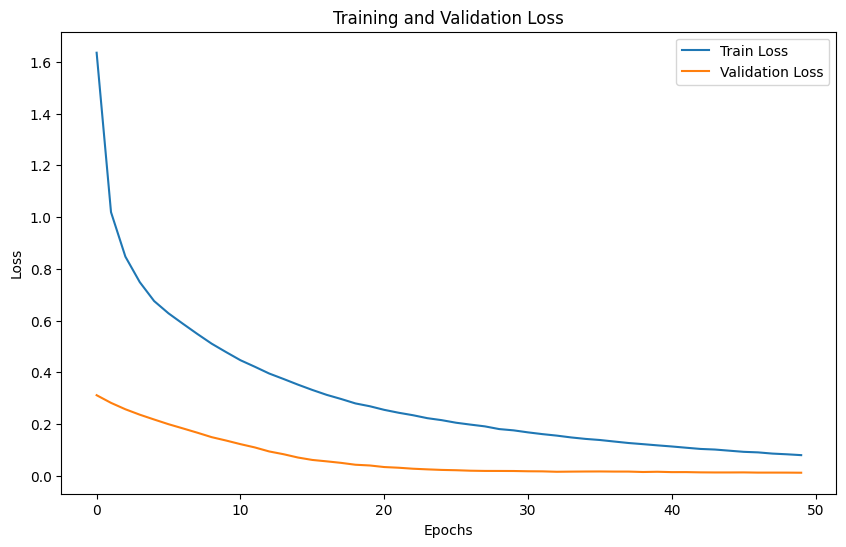

In [16]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


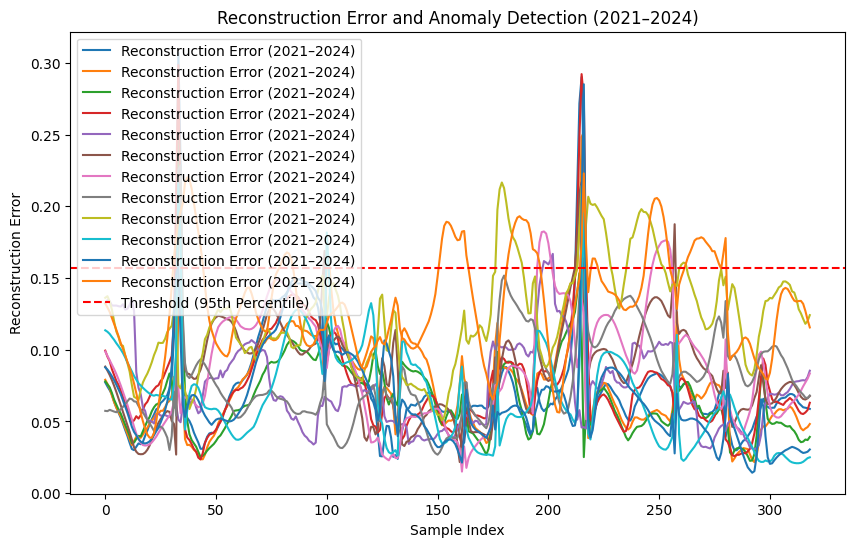

Number of anomalies detected: 192


In [17]:
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(reconstructed - X_test), axis=1)

plt.figure(figsize=(10, 6))
plt.plot(reconstruction_error, label='Reconstruction Error (2021–2024)')
plt.axhline(y=np.percentile(reconstruction_error, 95), color='r', linestyle='--', label='Threshold (95th Percentile)')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.title('Reconstruction Error and Anomaly Detection (2021–2024)')
plt.show()

threshold = np.percentile(reconstruction_error, 95)
anomalies = reconstruction_error > threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

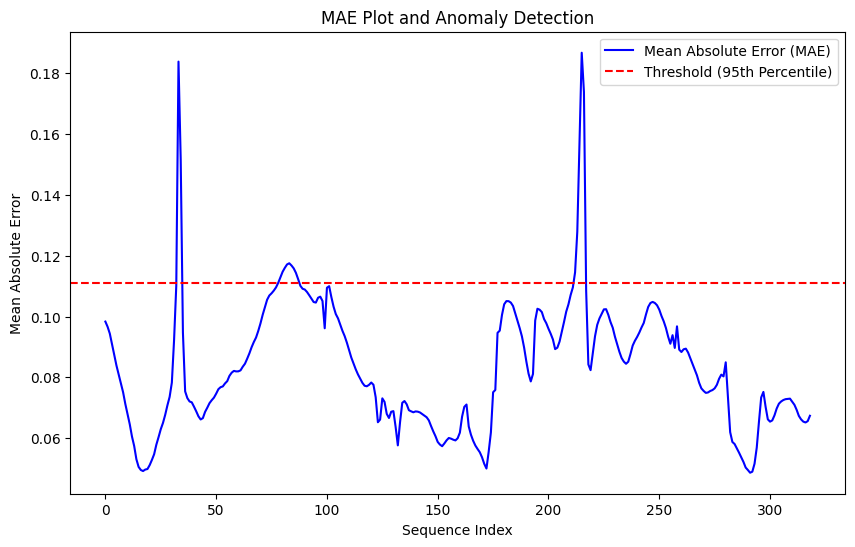

Number of anomalies detected (MAE): 16


In [18]:
mae = np.mean(np.abs(reconstructed - X_test), axis=(1, 2))

plt.figure(figsize=(10, 6))
plt.plot(mae, label='Mean Absolute Error (MAE)', color='blue')
plt.axhline(y=np.percentile(mae, 95), color='red', linestyle='--', label='Threshold (95th Percentile)')
plt.xlabel('Sequence Index')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('MAE Plot and Anomaly Detection')
plt.show()

# Detect anomalies based on MAE
threshold_mae = np.percentile(mae, 95)
anomalies_mae = mae > threshold_mae
print(f"Number of anomalies detected (MAE): {np.sum(anomalies_mae)}")


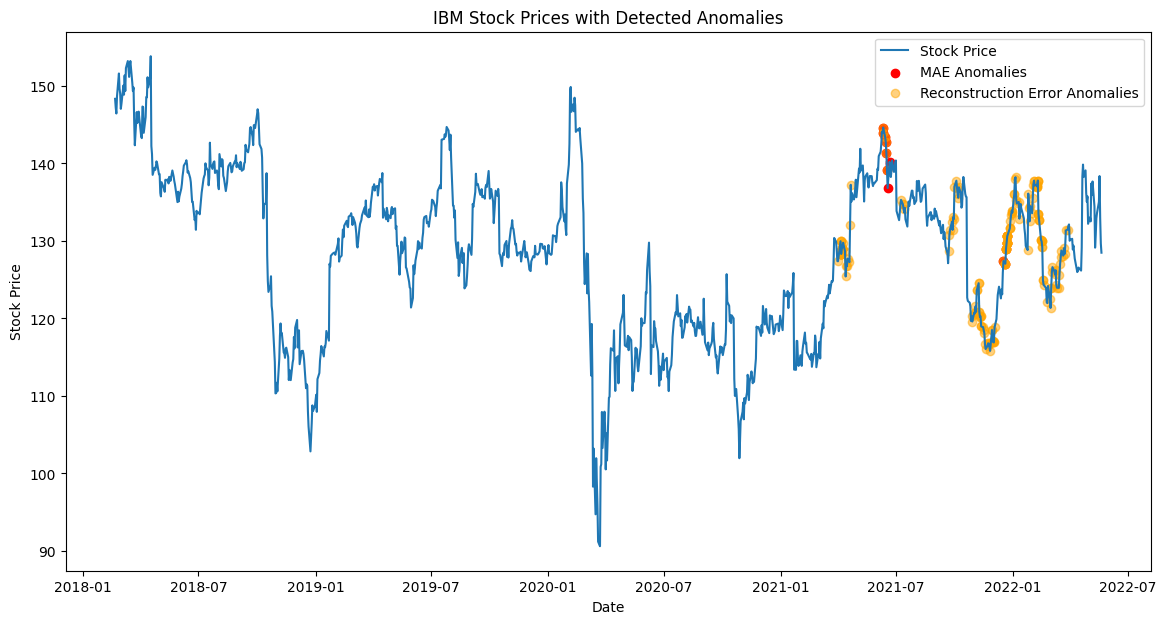

In [20]:
anomaly_indices_re = np.where(anomalies)[0]
anomaly_indices_mae = np.where(anomalies_mae)[0]

anomaly_dates_re = ibm_data.iloc[-len(X_test):].index[anomaly_indices_re]
anomaly_dates_mae = ibm_data.iloc[-len(X_test):].index[anomaly_indices_mae]

plt.figure(figsize=(14, 7))
plt.plot(ibm_data['Close'], label='Stock Price')
plt.scatter(anomaly_dates_mae, ibm_data.loc[anomaly_dates_mae, 'Close'], color='red', label='MAE Anomalies')
plt.scatter(anomaly_dates_re, ibm_data.loc[anomaly_dates_re, 'Close'], color='orange', label='Reconstruction Error Anomalies', alpha=0.5)
plt.legend()
plt.title('IBM Stock Prices with Detected Anomalies')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()
